In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve
import time, re, os, sys

from scipy.sparse import csr_matrix
from scipy.stats import zscore
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [2]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

enroll_spk.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
4780420411,0.014026,0.054789,0.025725,0.016863,0.063301,0.114704,0.070258,0.000567,0.045729,0.044964,...,0.077940,0.032820,0.022656,0.028034,0.035296,0.046987,0.036155,0.016219,0.011507,0.070774
4779876202,0.030303,0.022931,0.033079,0.058957,0.079296,0.049778,0.068490,0.003525,0.072742,0.030553,...,0.061358,0.044687,0.020264,0.007364,0.051940,0.062175,0.052892,0.026529,0.014570,0.025142
4778192381,0.055344,0.035090,0.026809,0.068782,0.045188,0.081985,0.033221,0.012631,0.026813,0.046449,...,0.075565,0.056208,0.029324,0.006928,0.055884,0.062326,0.022718,0.040709,0.015717,0.102008
4780265567,0.012624,0.058721,0.033892,0.054483,0.041132,0.115025,0.074992,0.000893,0.087311,0.076028,...,0.068856,0.051828,0.054921,0.011270,0.066159,0.043747,0.031619,0.033663,0.032096,0.073277
4777987958,0.054659,0.054360,0.014665,0.050420,0.064626,0.115716,0.107942,0.008013,0.069778,0.092527,...,0.102160,0.041830,0.015103,0.031850,0.061312,0.079773,0.071351,0.070432,0.031396,0.099793


In [42]:
ESPK = enroll_spk_raw
TSPK = test_spk_raw
score_func = 0

In [12]:
def run_test(score_func, sample_size = 0.10, ESPK = enroll_spk_raw, TSPK = test_spk):
    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = ESPK.loc[x['enroll']] # Pandas series
        test_data = TSPK.loc[x['test_id']]
        res = score_func(enroll_data, test_data)
        return res


    dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= sample_size, random_state=1)
    #dask_pairs = dd.from_pandas(pairs, npartitions=16)
    meta = ('x','f8')

    scores = 0
    
    pbar = ProgressBar()
    pbar.register()
    scores = dask_pairs.map_partitions(lambda df: df.apply(score_vectors ,axis=1), meta=meta)
    
    #New impl returns data in stacked format and takes 1/3 time
    
    scores = dask.array.from_delayed(delayed(np.vstack)(scores.values), shape=((1000,)), dtype='float64')
    scores = scores.rechunk((1000,))
    scores = scores.compute(get=get)
    pbar.unregister()
    
    res = 0
    res = dask_pairs['result'].values.compute()

    return scores, res

In [24]:
def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER: ", fpr[minPt])
    
    if name:
        plt.savefig(name)
    
    return

In [5]:
# For tests

spkr = enroll_spk_raw.loc[4780420411]
test = test_spk_raw.loc['fc_4779547143_0']

In [7]:
def read_trials(filename):
    df = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    return df

pairs = read_trials("trials")
print("num of trials: ",len(pairs))

# Encode "nontarget" as 0, "target as 1"
pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
pairs.head()

num of trials:  11725308


,enroll,test_id,result
0,4780420411,fc_4779547143_0,0
1,4780420411,fc_4779547143_1,0
2,4780420411,fc_4779547143_2,0
3,4780420411,fc_4779547143_3,0
4,4780420411,fc_4779547143_4,0


In [13]:
pairs[(pairs['enroll']==4780420411) & (pairs['result']==1)]

,enroll,test_id,result
5988,4780420411,fc_4780420411_0,1
5989,4780420411,fc_4780420411_1,1
5990,4780420411,fc_4780420411_2,1
5991,4780420411,fc_4780420411_3,1
5992,4780420411,fc_4780420411_4,1
5993,4780420411,fc_4780420411_5,1
5994,4780420411,fc_4780420411_6,1
5995,4780420411,fc_4780420411_7,1
4502097,4780420411,nc_4780420411_0,1
4502098,4780420411,nc_4780420411_1,1


## Plan
1. Estimate distributions of each speaker
2. Get probability that avg test vec is in that dist, make this the score

### 1. Assume gaussian dists

In [244]:
mean = np.mean(spkr, axis=0)
cov = np.cov(spkr, rowvar = False)

In [13]:
def zscore(dist1, dist2):
    cov = np.cov(dist1 , rowvar = False )
    u =np.mean(dist1, axis=0)
    x = (np.mean(dist2, axis=0))
    return np.sum(np.matmul(x-u, cov))

In [8]:
%load_ext line_profiler

In [11]:
%lprun -f zscore zscore(spkr, test)

In [14]:
zscore(spkr, test)

0.003234900347057228

In [ ]:
res = 0
res = dask_pairs['result'].values.compute()

calcEER(scores, res) 

### 1. Results

**0.47** EER this might not be viable, or formula needs to be revised

## 1a. Z-score where z-score is calculated column-wise for 400 variables and then summed

In [245]:
pairs.head()

,enroll,test_id,result
0,4780420411,fc_4779547143_0,0
1,4780420411,fc_4779547143_1,0
2,4780420411,fc_4779547143_2,0
3,4780420411,fc_4779547143_3,0
4,4780420411,fc_4779547143_4,0


In [242]:
np.count_nonzero(enroll_spk_raw.loc[4780420411].std(axis=0))

400

In [256]:
def zscore_col(dist1, dist2):
    var = np.std(dist1, axis=0)
    scores = np.absolute(np.divide((dist2-dist1.mean(axis=0)), var,where=var!=0))
    return np.sum(scores)

In [246]:
spkr = enroll_spk_raw.loc[4780420411]
test = test_spk.loc['fc_4779547143_0']

In [257]:
zscore_col(spkr, test)

1147.6701111903144

In [93]:
enroll_spk_raw.loc[4780319970]['136']
# When all column values are 0 for a speaker's vectors, this causes problems with division

utt
utt1    0.0
utt2    0.0
utt3    0.0
utt4    0.0
utt5    0.0
Name: 136, dtype: float64

In [90]:
print(enroll_spk_raw.loc[4780319970].std(axis=0))

0      0.005886
1      0.006822
2      0.003440
3      0.009707
4      0.011258
5      0.006193
6      0.015758
7      0.004971
8      0.008763
9      0.011439
10     0.006664
11     0.015116
12     0.005871
13     0.007955
14     0.007760
15     0.004314
16     0.009065
17     0.004496
18     0.006016
19     0.002228
20     0.009529
21     0.009580
22     0.004847
23     0.007300
24     0.015682
25     0.011731
26     0.009244
27     0.005784
28     0.014392
29     0.007693
30     0.003727
31     0.009306
32     0.005798
33     0.015436
34     0.004620
35     0.011637
36     0.012151
37     0.014581
38     0.005019
39     0.013985
40     0.008303
41     0.017241
42     0.002412
43     0.005635
44     0.010133
45     0.013725
46     0.005951
47     0.004955
48     0.010483
49     0.002790
50     0.006380
51     0.004390
52     0.011864
53     0.011676
54     0.007993
55     0.000741
56     0.005760
57     0.003267
58     0.005041
59     0.009830
60     0.014355
61     0.008804
62     0

In [278]:
scores, res = run_test(zscore_col, 0.1, enroll_spk_raw, test_spk)

[########################################] | 100% Completed | 22min 50.5s


ValueError: too many values to unpack (expected 2)

In [ ]:

scaler = MinMaxScaler()
scores_norm = scaler.fit_transform(np.array(scores).reshape((-1,1)))

In [ ]:
scores_norm = 1-scores_norm

0.2217058501913614

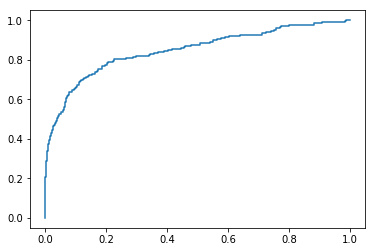

In [282]:
calcEER(scores_norm, res)

# 1a. Results
1. Z-score

    a. 0.01 Sample - **0.22170** EER - Took column-wise z-score of avg test vector on distribution of enroll speaker utterances and summed absolute value of z-scores
    
    b. 0.10 Sample - **


# 1b. ML with Cosine Similarity and Variance as features

In [6]:
def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

In [8]:
cos_scores, cos_res = run_test(cos_similarity, 0.10, enroll_spk, test_spk)

[########################################] | 100% Completed |  1min  7.7s


0.08507121655384484

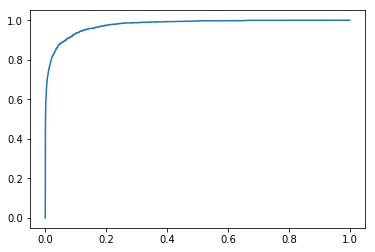

In [9]:
calcEER(cos_scores, cos_res) # EER with just cosine sim 

In [14]:
enroll_spk_raw.loc[4780420411].values.var(axis=0).shape

(400,)

In [5]:
def cos_with_variance(dist1, vect2):
    m = dist1.mean(axis=0)
    cos = 1 - cosine(m, vect2)
    v = dist1.var(axis=0)
    return np.concatenate([np.array([cos]), v])

In [7]:
spkr = enroll_spk_raw.loc[4780420411]
test = test_spk.loc['fc_4779547143_0']
x = cos_with_variance(spkr, test)

In [13]:
X, Y = run_test(cos_with_variance, 0.01)

[########################################] | 100% Completed | 32.3s


In [14]:
X_csr = csr_matrix(np.vstack(X.values))

In [14]:
svc = SVC(kernel='linear', probability = True, random_state = 1, verbose = True, cache_size= 2000, max_iter=300)  
svc.fit(X_csr, Y) 

[LibSVM]

/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=2000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=300, probability=True, random_state=1, shrinking=True,
  tol=0.001, verbose=True)

In [15]:
cos_svm_scores = svc.decision_function(X_csr)

In [35]:
cos_svm_scores[13911]

-1.0000187750695377

In [19]:
scores = svc.predict(X_csr)

In [21]:
(scores==Y).sum()/len(scores)

0.9983624454148472

In [24]:
sum((scores==1)& (Y==0))

0

In [25]:
sum((scores==0)& (Y==1)) # Y ends up having 192 instances of '1' in total for this trial, meaning SVM just predicted everything as '0'

192

0.40620728540185896

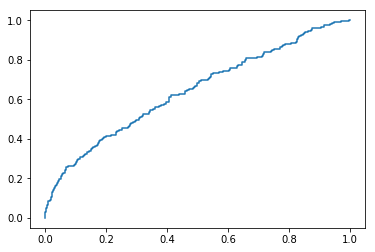

In [22]:
calcEER(cos_decisions, Y)

6/26 - Ask Dr. Tang about why high accuracy but also high EER. How do we use ML models to produce results and calculate EER?

In [21]:
X, Y = run_test(cos_with_variance, 0.01)
X_csr = csr_matrix(np.vstack(X.values))
rf = RandomForestClassifier(verbose = 1, n_jobs=8)
rf.fit(X_csr, Y)

[########################################] | 100% Completed | 35.3s
[########################################] | 100% Completed | 35.4s
[########################################] | 100% Completed | 35.4s
[########################################] | 100% Completed | 35.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    5.0s remaining:    3.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    7.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

Threshold:  0.2
EER:  0.000555289775833789


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


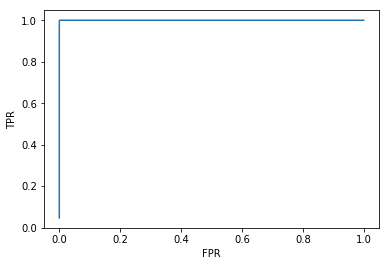

In [62]:
cos_rf_prob = rf.predict_proba(X_csr)
calcEER(cos_rf_prob[:,1], Y)

In [36]:
# Using RF trained on 0.01 of data to predict values of 0.10 of data
X_tenth, Y_tenth = run_test(cos_with_variance, 0.1)
X_tenth_csr = csr_matrix(np.vstack(X_tenth.values))

cos_rf_prob_tenth = rf.predict_proba(X_tenth_csr)
calcEER(cos_rf_prob_tenth[:,1], Y_tenth)

[                                        ] | 0% Completed | 15.9s


KeyboardInterrupt: 

In [48]:
sum(Y_tenth==1)

1803

In [51]:
preds = rf.predict(X_tenth_csr)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.0s finished


In [54]:
(preds==Y_tenth).sum()/len(preds) # Accuracy with tenth predictions

0.998402596782337

## What if RF was trained on just cosine similarity?

In [9]:
X_cos, Y_cos = run_test(cos_similarity, 0.01, enroll_spk, test_spk)

[########################################] | 100% Completed | 18.4s


In [12]:
rf_cos = RandomForestClassifier(verbose = 1, n_jobs=8)
X_cos_a = np.array(X_cos).reshape((-1,1))
rf_cos.fit(X_cos_a, Y_cos)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


0.0005980043739748496

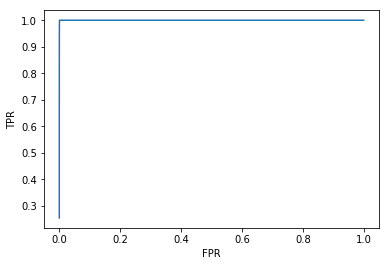

In [13]:
cos_only_rf_prob = rf_cos.predict_proba(X_cos_a)
calcEER(cos_only_rf_prob[:,1], Y_cos)

[########################################] | 100% Completed |  1min  6.5s


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished


0.0027957035170513996

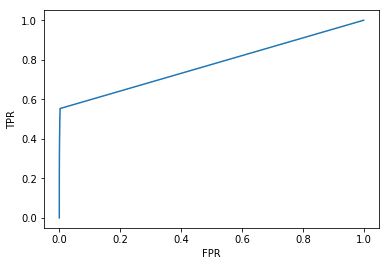

In [14]:
X_cos_tenth, Y_cos_tenth = run_test(cos_similarity, 0.1, enroll_spk, test_spk)
X_cos_a = np.array(X_cos_tenth).reshape((-1,1))
cos_only_rf_prob_tenth = rf_cos.predict_proba(X_cos_a)
calcEER(cos_only_rf_prob_tenth[:,1], Y_cos_tenth)

Threshold:  0.025
EER:  0.0027957035170513996


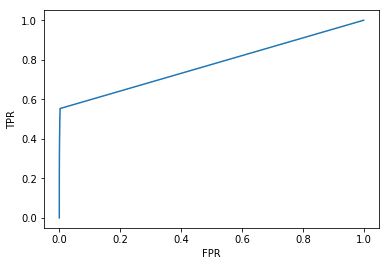

In [32]:
calcEER(cos_only_rf_prob_tenth[:,1], Y_cos_tenth)

## Some verification

In [17]:
sum(Y_cos_tenth==1)/len(Y_cos_tenth)

0.0015377031507989574

In [20]:
len(pairs[pairs['result']==1])

17892

In [22]:
np.histogram(cos_only_rf_prob_tenth[:,1])

(array([1168348,    1149,     831,      23,     226,     635,     384,
              0,     283,     649]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

We see that in the histogram of our 10% data, the probabilities are heavily skewed towards 0. Since we have few true pairs, we can try to see what kind of probabilities for possible matches end up being true matches.

In [23]:
trues = np.where(Y_cos_tenth==1)
true_probs = cos_only_rf_prob_tenth[trues]

In [26]:
np.histogram(true_probs[:,1]) # This result is meaningful only if we know the threshold 

(array([806,  89, 130,   3,  29, 110,  92,   0, 104, 440]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [38]:
def calcEER_print(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    print(fpr)
    print(tpr)
    print(thresholds)
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER: ", fpr[minPt])
    
    return

In [40]:
calcEER_print(cos_only_rf_prob_tenth[:,1], Y_cos_tenth)

[0.00000000e+00 6.57712101e-05 1.78521856e-04 3.31418565e-04
 5.68024088e-04 5.72294945e-04 5.75711632e-04 5.80836661e-04
 7.98650409e-04 1.02927673e-03 1.03525593e-03 1.19754853e-03
 1.19840270e-03 1.20438190e-03 1.21206944e-03 1.21292362e-03
 1.21463196e-03 1.42304982e-03 1.43159154e-03 1.43329988e-03
 1.44013325e-03 1.81340622e-03 1.81426039e-03 1.82194794e-03
 1.82365628e-03 1.82707297e-03 1.82792714e-03 2.71882808e-03
 2.72395311e-03 2.72480728e-03 2.73932819e-03 2.76580751e-03
 2.79399517e-03 2.79570352e-03 1.00000000e+00]
[0.         0.19190238 0.24403771 0.30171936 0.3505269  0.35108153
 0.35219079 0.35274542 0.38713256 0.41375485 0.41430948 0.42983916
 0.43039379 0.43094842 0.43150305 0.43150305 0.43150305 0.4608985
 0.46145313 0.46145313 0.46200776 0.5036051  0.5036051  0.5036051
 0.5036051  0.5036051  0.5036051  0.55296728 0.55296728 0.55296728
 0.55296728 0.55352191 0.55352191 0.55352191 1.        ]
[2.         1.         0.9        0.8        0.7        0.63333333
 0.62333

## 2. Mahalanobis distance

In [291]:
def md(dist1, dist2):
    cov = np.cov(dist1, rowvar = False )
    t = np.mean(dist1, axis=0)
    #i = np.linalg.inv(cov)
    x = t-dist2
    return np.absolute(np.matmul(np.matmul(x.T, cov), x))

In [292]:
spkr = enroll_spk_raw.loc[4780420411]
test = test_spk.loc['fc_4779547143_0']

md(spkr, test)

0.00016605474033094662

In [30]:
%lprun -f md md(spkr, test)

In [293]:
scores, res = run_test(md, 0.01, enroll_spk_raw, test_spk) #Singular matrix problem - COV is singular

[########################################] | 100% Completed |  3min  2.7s
[########################################] | 100% Completed |  3min  2.7s
[########################################] | 100% Completed |  0.3s


In [295]:
scaler.fit_transform(np.array(scores).reshape((-1,1)))
scores = 1-scores

0.4827347594313833

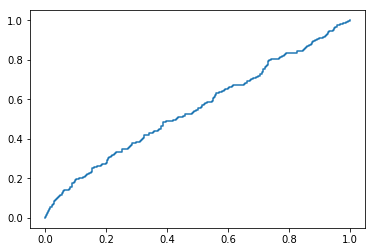

In [296]:

calcEER(scores, res)

## Investigation of data integrity
To investigate why all utterances of several speakers had 0 values in their means, the above series of steps shows the processed data at different points of data processing. It was found that the 0 values may be coincidental, but valid. Need confirmation that this can happen in d-vectors.

The steps were taken:
1. Print speaker id's that had 0's in its variance vector, which would only occur if at a specific index across all 5 utterances, there was a 0 instead of a real value. This turned out to be a lot of speakers.
2. Observe enroll_spk, and then enroll_spk_raw. Both were checked for 0's and 0's were found at a single index.
3. It was found that averaged vectors for each utterance had 0's, so a single utterance was investigated within enroll_ark, and then enroll.ark to confirm that the averages were correct. 

Alternative steps that could have been taken:
1. Work from the bottom up - start with enroll.ark and confirm that data is valid
2. Assign a threshold to the 0's?

In [221]:
def search_spk(filename, spk):
    """Searches spk2utt file given speaker id"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    return df[df['id']== spk]

def search_ark(filename, utt):
    """Searches an arkfile given the name of a target utt"""
    working_data = []
    utt_id_past = ""
    with open(FILE_DIR+filename, 'r') as f:
        for line in f:
            if(line[:2].isalpha()):
                utt_id = line[:line.index("[")-2]
                if utt_id_past == utt:
                    return np.array(working_data, dtype = 'float64')
                utt_id_past = utt_id
                working_data = []
            else:
                # Add line as another row to the working matrix of df_utterance
                if "]" in line[-3:]: line = line[:-2]
                working_data.append(line.strip().split())
    return 0 

In [6]:
enroll_ark = dd.read_hdf("enroll.ark.h5", key='/*')

In [20]:
search_spk("enroll.spk2utt", 4780319970)

,id,utt1,utt2,utt3,utt4,utt5
31,4780319970,nn_1025806227919689079_1,nn_1025806227919689079_2,nn_1025806227919689079_3,nn_1025806227919689079_4,nn_1025806227919689079_5


In [43]:
a = search_ark("enroll.ark", "nn_1025806227919689079_1")

In [148]:
def read_spk2utt_raw(filename, ark_df, search):
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    target = df[df['id']==search]
    print(target.values[0][1:])
 
    return [(ark_df.loc[y].values).compute() for y in target.values[0][1:]]

   

In [149]:
t = read_spk2utt_raw("enroll.spk2utt", enroll_ark, 4780319970)

['nn_1025806227919689079_1' 'nn_1025806227919689079_2'
 'nn_1025806227919689079_3' 'nn_1025806227919689079_4'
 'nn_1025806227919689079_5']


In [178]:
enroll_ark.loc['nn_1025806227919689079_1'].compute().values[0][136]

0.0

In [222]:
true_ark = search_ark("enroll.ark", 'nn_1025806227919689079_1')
true_ark

array([[0.2965343 , 1.049055  , 0.        , ..., 0.1533272 , 0.4349658 ,
        1.951082  ],
       [0.3154624 , 0.9789277 , 0.        , ..., 0.1272981 , 0.4428131 ,
        1.919077  ],
       [0.3061154 , 0.906414  , 0.        , ..., 0.1150088 , 0.3520756 ,
        1.847408  ],
       ...,
       [1.459213  , 0.3537721 , 0.        , ..., 0.        , 1.423177  ,
        0.2227626 ],
       [1.352517  , 0.3202083 , 0.        , ..., 0.        , 1.298595  ,
        0.1407503 ],
       [1.428678  , 0.207373  , 0.        , ..., 0.        , 1.26614   ,
        0.08875074]])

In [84]:
enroll_spk_raw.loc[4780319970]['136']

utt
utt1    0.0
utt2    0.0
utt3    0.0
utt4    0.0
utt5    0.0
Name: 136, dtype: float64

In [239]:
true_ark[:,136]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.